In [1]:
# !pip install numpy
# !pip install pandas

In [38]:
import numpy as np
import pandas as pd
from faker import Faker
import random

#Code for generating a baby dataset



name_gen = Faker()
num_samples = 9

height = list(np.random.normal(loc=50, scale=1, size=num_samples))

classic_icecreams = [
    "Vanilla", "Chocolate", "Strawberry", "Mint Chocolate Chip",
    "Cookies and Cream", "Rocky Road", "Butter Pecan", "Neapolitan",
    "Pistachio", "French Vanilla"
]

fav_icecream = list(random.choices(classic_icecreams, k=num_samples))


In [39]:
# Generate random first and last names
name_df = pd.DataFrame({
    'First_Name': [name_gen.first_name() for _ in range(num_samples)],
    'Last_Name': [name_gen.last_name() for _ in range(num_samples)]
})

height_df = pd.DataFrame({'Height': height})

icecream_df = pd.DataFrame({'Flavour': fav_icecream})

full_df = pd.concat([name_df, height_df, icecream_df], axis=1)

In [40]:
from sklearn.manifold import TSNE
from saiph.projection import fit_transform
from sklearn.preprocessing import LabelEncoder

sens_individual = ['John', 'Davies', 182.5, 'Vanilla']
new_individual_df = pd.DataFrame([sens_individual], columns=full_df.columns)
all_individuals = pd.concat([full_df, new_individual_df], ignore_index=True)
print(all_individuals)


#PCA
coord_real_pca, model_pca = fit_transform(all_individuals, nf=2)

  First_Name Last_Name      Height              Flavour
0    Kristin  Robinson   51.764052            Pistachio
1     Robert  Anderson   50.400157           Neapolitan
2       Eric      Boyd   50.978738    Cookies and Cream
3    Timothy     Henry   52.240893           Strawberry
4      Tammy     Perez   51.867558           Rocky Road
5   Jonathan   Johnson   49.022722    Cookies and Cream
6  Elizabeth    Warren   50.950088           Neapolitan
7    Kaitlyn   Walters   49.848643  Mint Chocolate Chip
8     Jeremy   Johnson   49.896781    Cookies and Cream
9       John    Davies  182.500000              Vanilla


  First_Name Last_Name     Height              Flavour
0    Kaitlyn   Walters  49.848643  Mint Chocolate Chip
1     Robert  Anderson  50.400157           Neapolitan
2    Timothy     Henry  52.240893           Strawberry
3     Robert  Anderson  50.400157           Neapolitan
4       Eric      Boyd  50.978738    Cookies and Cream
5    Timothy     Henry  52.240893           Strawberry
6      Tammy     Perez  51.867558           Rocky Road
7       John    Davies      182.5              Vanilla
8   Jonathan   Johnson  49.022722    Cookies and Cream
9      Tammy     Perez  51.867558           Rocky Road


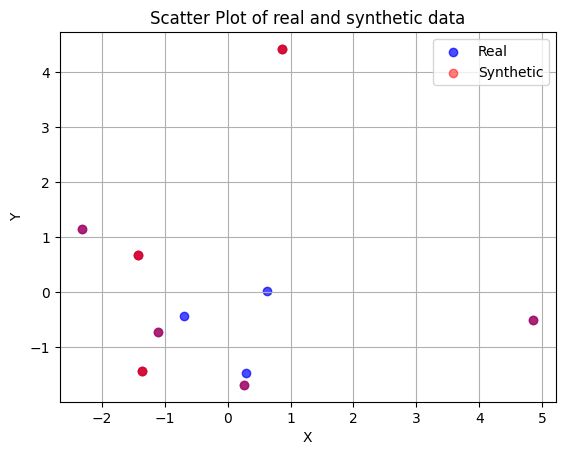

In [41]:
#Make a synthetic dataset
from synthesis.synthesizers.privbayes import PrivBayes
from saiph.projection import transform

eps=np.inf
epsilon = eps

pb = PrivBayes(epsilon=epsilon, verbose=False)

pb.fit(all_individuals)

gen_data  = pb.sample()

final_data = pd.DataFrame(gen_data.values, columns=gen_data.columns, index=range(all_individuals.shape[0]))

print(final_data)

import matplotlib.pyplot as plt
    
def scatter_plot(coord_real, coord_synth):
    # Scatter Plot
    plt.figure()

    # Plot DataFrame 1
    plt.scatter(coord_real['Dim. 1'], coord_real['Dim. 2'], color='blue', label='Real', alpha=0.7)

    # Plot DataFrame 2
    plt.scatter(coord_synth['Dim. 1'], coord_synth['Dim. 2'], color='red', label='Synthetic', alpha=0.5)

    plt.title('Scatter Plot of real and synthetic data')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)

    # Show Plot
    plt.show()

#PCA
syn_coords_pca = transform(final_data, model_pca)
scatter_plot(coord_real_pca, syn_coords_pca)

In [52]:
from sklearn.preprocessing import LabelEncoder


#Import metrics
from Metrics import All_synthcity

all_individuals['Height'].astype('Float32')
final_data['Height'].astype('Float32')

le = LabelEncoder()
r_fn = le.fit_transform(all_individuals['First_Name'])
r_ln = le.fit_transform(all_individuals['Last_Name'])
r_fl = le.fit_transform(all_individuals['Flavour'])
x_ = pd.DataFrame({'First_Name':r_fn, 'Last_Name': r_ln, 'Height': final_data['Height'],'Flavour':r_fl})

s_fn = le.fit_transform(final_data['First_Name'])
s_ln = le.fit_transform(final_data['Last_Name'])
s_fl = le.fit_transform(final_data['Flavour'])
z_ = pd.DataFrame({'First_Name':s_fn, 'Last_Name': s_ln, 'Height': final_data['Height'],'Flavour':s_fl})



metrics = {
                'sanity': ['common_rows_proportion', 'nearest_syn_neighbor_distance', 'close_values_probability', 'distant_values_probability'],
                'stats': ['alpha_precision'],
                'detection': ['detection_mlp'],
                'privacy': ['identifiability_score'],
            }

synthcity_results = All_synthcity.calculate_metric(args = None, _real_data=x_, _synthetic=z_, _metrics=metrics)

crp = synthcity_results['mean'][1]
nsnd = 1-synthcity_results['mean'][2]
cvp = synthcity_results['mean'][3]
dvp = 1-synthcity_results['mean'][4]
auth = synthcity_results['mean'][10]
mlp = synthcity_results['mean'][11]
id_score = synthcity_results['mean'][12]

from Metrics import AttributeInference as AIR
from Metrics import CGeneralizedCAP as GCAP
from Metrics import CZeroCAP as CZCAP
from Metrics import DCR
from Metrics import NNDR
from Metrics import Hidden_rate
from Metrics import NNAA
from Metrics import MemInf as MIR
from Metrics import Hitting_rate
from Metrics import MDCR



air = AIR.calculate_metric(args = None, _real_data=all_individuals, _synthetic=final_data)
gcap = GCAP.calculate_metric(args = None, _real_data=x_, _synthetic=z_)
zcap = CZCAP.calculate_metric(args = None, _real_data=x_, _synthetic=z_)
mdcr = MDCR.calculate_metric(args=None, _real_data=x_, _synthetic=z_)
hitR = Hitting_rate.calculate_metric(args=None, _real_data=x_, _synthetic=z_)
mir = MIR.calculate_metric(args=None, _real_data=x_, _synthetic=z_)
nnaa = NNAA.calculate_metric(args=None, _real_data=x_, _synthetic=z_)
# dcr, nndr, hidR = calculate_dcr_nndr_hidr(args=None, _real_data=x_, _synthetic=z_)

from IPython.display import clear_output
for i in range(10):
    clear_output(wait=True)

results = {'AIR':round(air, 2),'GCAP': round(gcap, 2), 'ZCAP':round(zcap, 2), 
           'MDCR':round(mdcr, 2), 'Hitting_rate':round(hitR, 2), 'MIR':round(mir, 2), 
           'NNAA':round(nnaa, 2), 'CRP':round(crp, 2), 'NSND':round(nsnd, 2), 
           'CVP':round(cvp, 2), 'DVP':round(dvp, 2), 'Authenticity':round(auth, 2), 
           'DetectionMLP':round(mlp, 2), 'Identifiability_score':round(id_score, 2)}


print(results)




{'AIR': 0.46, 'GCAP': 0.24, 'ZCAP': 0.1, 'MDCR': 0.76, 'Hitting_rate': 0.2, 'MIR': 1.0, 'NNAA': 0.6, 'CRP': 0.65, 'NSND': 0.9, 'CVP': 0.2, 'DVP': 0.91, 'Authenticity': 0.47, 'DetectionMLP': 0.5, 'Identifiability_score': 0.1}


In [7]:
#Code modified from https://github.com/octopize/avatar-paper
import pandas as pd
import numpy as np
import statistics
from saiph.projection import fit_transform
from saiph.projection import transform
from math import log
from typing import Tuple, Union
import faiss
import math
from numpy.typing import NDArray
from numpy import bool_
from sklearn.neighbors import NearestNeighbors

def calculate_dcr_nndr_hidr(args, _real_data, _synthetic):
    real_data = _real_data
    synthetic = _synthetic

    # cat_vars = ['First_Name', 'Last_Name', 'Flavour']
    # real_data[cat_vars].astype("category")
    # real_data['Height'].astype(np.float32)
    
    # #Assign categorical values with type "category" for both real and synthetic data
    # categorical_val_real, continuous_val_real = get_categorical_continuous(real_data)
    # real_data[categorical_val_real] = real_data[categorical_val_real].astype("category")
    
    # categorical_val_synth, continous_val_synth = get_categorical_continuous(synthetic)
    # synthetic[categorical_val_synth] = synthetic[categorical_val_synth].astype("category")

    #Fit model and get coordinates
    real_coord, model = fit_transform(real_data, nf=2)
    synth_coord = transform(synthetic, model)

    dcr = statistics.mean(get_dcr(real_coord, synth_coord))
    
    if dcr == 0:
        dcr = 1
    else:
        dcr = 1 - sigmoid(log(dcr, 10))
    
    nndr = 1 - statistics.mean(get_nndr(real_coord, synth_coord))
    
    are_first_hit = avatars_are_k_hit(
            real_coord, synth_coord, distance_metric="minkowski", k=1
        )
    
    hiddr = calc_hidden_rate(are_first_hit)
    
    return dcr, nndr, hiddr
    
def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

#Return column names of the categorical(strings) and continuous(integers) attributes
def get_categorical_continuous(data: pd.DataFrame):
    categorical_val = []
    cont_val = []
    for column in data.columns:
            if data[column].dtype == 'O':
                categorical_val.append(column)
            else:
                cont_val.append(column)
    
    return categorical_val, cont_val


def get_dcr(train_coord, synth_coord):
    """Get distances to the closest records.

    DCR is the distance of each synthetic record to a record in the original dataset.
    """
    indices_distances = get_distances_closest_records(
        train_coord, synth_coord, searching_frame=1
    )
    _, distances = zip(*indices_distances)
    return [distance[0] for distance in distances]

def get_nndr(train_coord, synth_coord):
    """Get nearest neighbors distance ratio.

    Ratio of the distance of each synthetic record to its closest
    to the second closest record in the original dataset.
    """
    indices_distances = get_distances_closest_records(
        train_coord, synth_coord, searching_frame=2
    )
    _, distances = zip(*indices_distances)

    ratio = [
        1 if distance[1] == 0 else distance[0] / distance[1] for distance in distances
    ]
    return ratio

def calc_hidden_rate(are_first_hit: NDArray[bool_]) -> float:
    """Test for each record if the nearest avatar is the one generated by the original record itself.

    Arguments:
        are_first_hit: whether the nearest neighbor of the supplied
          original record is the avatar created from this record

    Returns:
        float: the percentage of records that could be considered "safe"
    """
    res: float = (are_first_hit.sum() / len(are_first_hit))
    return res

def avatars_are_k_hit(
    records_coordinates: pd.DataFrame,
    avatars_coordinates: pd.DataFrame,
    distance_metric: str = "minkowski",
    k: int = 1,
) -> NDArray[np.bool_]:
    """Test for each record if the nearest avatar is the one generated by the original record itself.

    Arguments:
        records_coordinates
        avatars_coordinates
        distance_metric
        k

    Returns:
        array: whether the nearest neighbor of the supplied original
          record is the avatar created from this record
    """
    if distance_metric not in [
        "cityblock",
        "cosine",
        "euclidean",
        "l1",
        "l2",
        "manhattan",
        "braycurtis",
        "canberra",
        "chebyshev",
        "correlation",
        "dice",
        "hamming",
        "jaccard",
        "kulsinski",
        "mahalanobis",
        "minkowski",
        "rogerstanimoto",
        "russellrao",
        "seuclidean",
        "sokalmichener",
        "sokalsneath",
        "sqeuclidean",
        "yule",
    ]:
        raise ValueError("distance_metric", "invalid distance metric")

    #if records_coordinates.shape[0] != avatars_coordinates.shape[0]:
    #    raise ValueError(
    #        "dimension",
    #        "Records set and synthetic set dataframes must have the same number of observations",
    #    )

    if distance_metric == "minkowski":
        nn = FaissKNeighbors(k=k)
        nn.fit(np.array(avatars_coordinates))
        distances, indices = nn.predict(np.array(records_coordinates))
    else:
        nn = NearestNeighbors(
            n_neighbors=1, algorithm="ball_tree", metric=distance_metric
        )
        nn.fit(avatars_coordinates)
        distances, indices = nn.kneighbors(records_coordinates)  # type: ignore

    indices_array: NDArray[np.int_] = np.array([item[0] for item in indices])

    are_k_hit: NDArray[np.bool_] = np.equal(
        indices_array, range(0, records_coordinates.shape[0])
    )

    return are_k_hit

def get_distances_closest_records(
    records: pd.DataFrame, synthetic: pd.DataFrame, searching_frame: int
):
    """Get index and distances of the closest records.

    Arguments
    ---------
        records: Original records
        synthetic: Synthetic data
        searching_frame: number of neighbors to find
    Returns
    -------
        indices_distances: indices, distances nearest neighbor among original records.

    """
    nn = FaissKNeighbors(k=searching_frame)
    nn.fit(np.array(records))

    # index.search returns two arrays (distances, indices)
    # https://github.com/facebookresearch/faiss/wiki/Getting-started
    distances, indices = nn.predict(synthetic.to_numpy().astype(np.float32))

    indices_distances = list(zip(indices, distances))
    return indices_distances

class FaissKNeighbors:
    index: Union[faiss.IndexFlatL2, faiss.IndexIVFFlat]

    def __init__(self, k: int = 5) -> None:
        self.index = faiss.IndexFlatL2()
        self.k = k

    def fit(self, X: NDArray[np.float_]) -> None:
        xb: NDArray[np.float_] = X.astype(np.float32)
        size, dimension = X.shape
        nlist = round(math.sqrt(size))
        threshold_size = 50000

        # Use Index for large size dataframe
        if size > threshold_size:
            quantizer = faiss.IndexFlatL2(dimension)
            self.index = faiss.IndexIVFFlat(
                quantizer, dimension, nlist, faiss.METRIC_L2
            )
            assert self.index is not None  # nosec: B101
            self.index.train(xb)

        # perform exhaustive search otherwise
        else:
            self.index = faiss.IndexFlatL2(dimension)

        assert self.index is not None  # nosec: B101
        self.index.add(xb)

    def predict(
        self, X: NDArray[np.float_]
    ) -> Tuple[NDArray[np.float_], NDArray[np.int_]]:
        assert self.index is not None  # nosec: B101
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        distances = np.sqrt(distances)
        return distances, indices

ColumnsNotFoundError: Expected columns to be the same as the ones used in the model.Got set().

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def scatter_plot_tsne(coord_real, coord_synth):
    real = pd.DataFrame(coord_real)
    syn = pd.DataFrame(coord_synth)
    coords = pd.merge(real, syn)
    # Scatter Plot
    plt.figure()

    # Plot DataFrame 1
    plt.scatter(real[0], real[1], color='blue', label='Real', alpha=0.5)

    # Plot DataFrame 2
    plt.scatter(syn[0], syn[1], color='red', label='Synthetic', alpha=0.5)

    plt.title('Scatter Plot of real and synthetic data')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)

    # Show Plot
    plt.show()


tsne = TSNE(n_components=2)

tsne_coord_real = tsne.fit_transform(all_individuals)

tsne_coord_syn = tsne.fit_transform(final_data)

scatter_plot_tsne(tsne_coord_real, tsne_coord_syn)

In [ ]:
from saiph.projection import fit_transform
from saiph.projection import transform

def scatter_plot(coord_real, coord_synth):
    # Scatter Plot
    plt.figure()

    # Plot DataFrame 1
    plt.scatter(coord_real['Dim. 1'], coord_real['Dim. 2'], color='blue', label='Real', alpha=0.7)

    # Plot DataFrame 2
    plt.scatter(coord_synth['Dim. 1'], coord_synth['Dim. 2'], color='red', label='Synthetic', alpha=0.5)

    plt.title('Scatter Plot of real and synthetic data')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)




    # Show Plot
    plt.show()
    
pca_coord_real, model = fit_transform(all_individuals, nf=2)
pca_coord_syn = transform(final_data, model)

scatter_plot(pca_coord_real, pca_coord_syn)